In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from forecast_combine.reconcile import ForecastReconciler
today = pd.Timestamp.today().strftime('%Y-%m-%d')

In [12]:
CIC = pd.read_excel('../data/CIC.xlsx', parse_dates=['date'], index_col='date').squeeze()
holiday_type = pd.read_excel('../data/holidays.xlsx', parse_dates=['date'], index_col='date')
holiday_type = pd.get_dummies(holiday_type['Type']).astype(int)
CIC_X = holiday_type.resample('B').last().fillna(0)

In [13]:
NFA = pd.read_excel('../data/NFA.xlsx', parse_dates=['date'], index_col='date').squeeze()

dateindex = pd.date_range(start=NFA.index[0], 
                             end=NFA.index[-1] + pd.Timedelta(days=365),
                            freq='B')
exogs = pd.DataFrame(index=dateindex)

exogs['trend'] = np.arange(len(exogs))
# Define seasonalities based on your original expressions
exogs['yearly_season'] = np.sin(2 * np.pi * exogs['trend'] / 260)  # Assuming 260 working days per year for yearly seasonality
exogs['monthly_season'] = np.sin(2 * np.pi * exogs['trend'] / 22)  # Assuming about 22 working days per month
exogs['weekly_season'] = np.sin(2 * np.pi * exogs['trend'] / 5)   # Assuming 5 working days per week
exogs['break'] = np.where(exogs.index > '2020-01-06', 1, 0)

NFA_X = exogs

In [14]:
SAB  = pd.read_excel('../data/SAB.xlsx', parse_dates=['date'], index_col='date').squeeze()
Total_AF = NFA - CIC - SAB

In [15]:
# trained models for each autonomous factor
output_folder = '../model_output/'
model_names = ['CIC', 'NFA', 'SAB', 'Total_AF']
forecasters_d = {}
for model_name in model_names:
    with open(output_folder + model_name + '_forecast.pkl', 'rb') as f:
        forecasters_d[model_name] = pickle.load(f)    

# Hierarchical relationship matrix
S = pd.DataFrame(np.array([[1,-1,-1], [1,0,0], [0,1,0], [0,0,1]]), 
                 columns=['NFA', 'CIC', 'SAB',], 
                 index=['Total_AF', 'NFA', 'CIC', 'SAB'])

# Hiearchical reconciliation model
reconciler = ForecastReconciler(forecasters_d=forecasters_d, S = S)

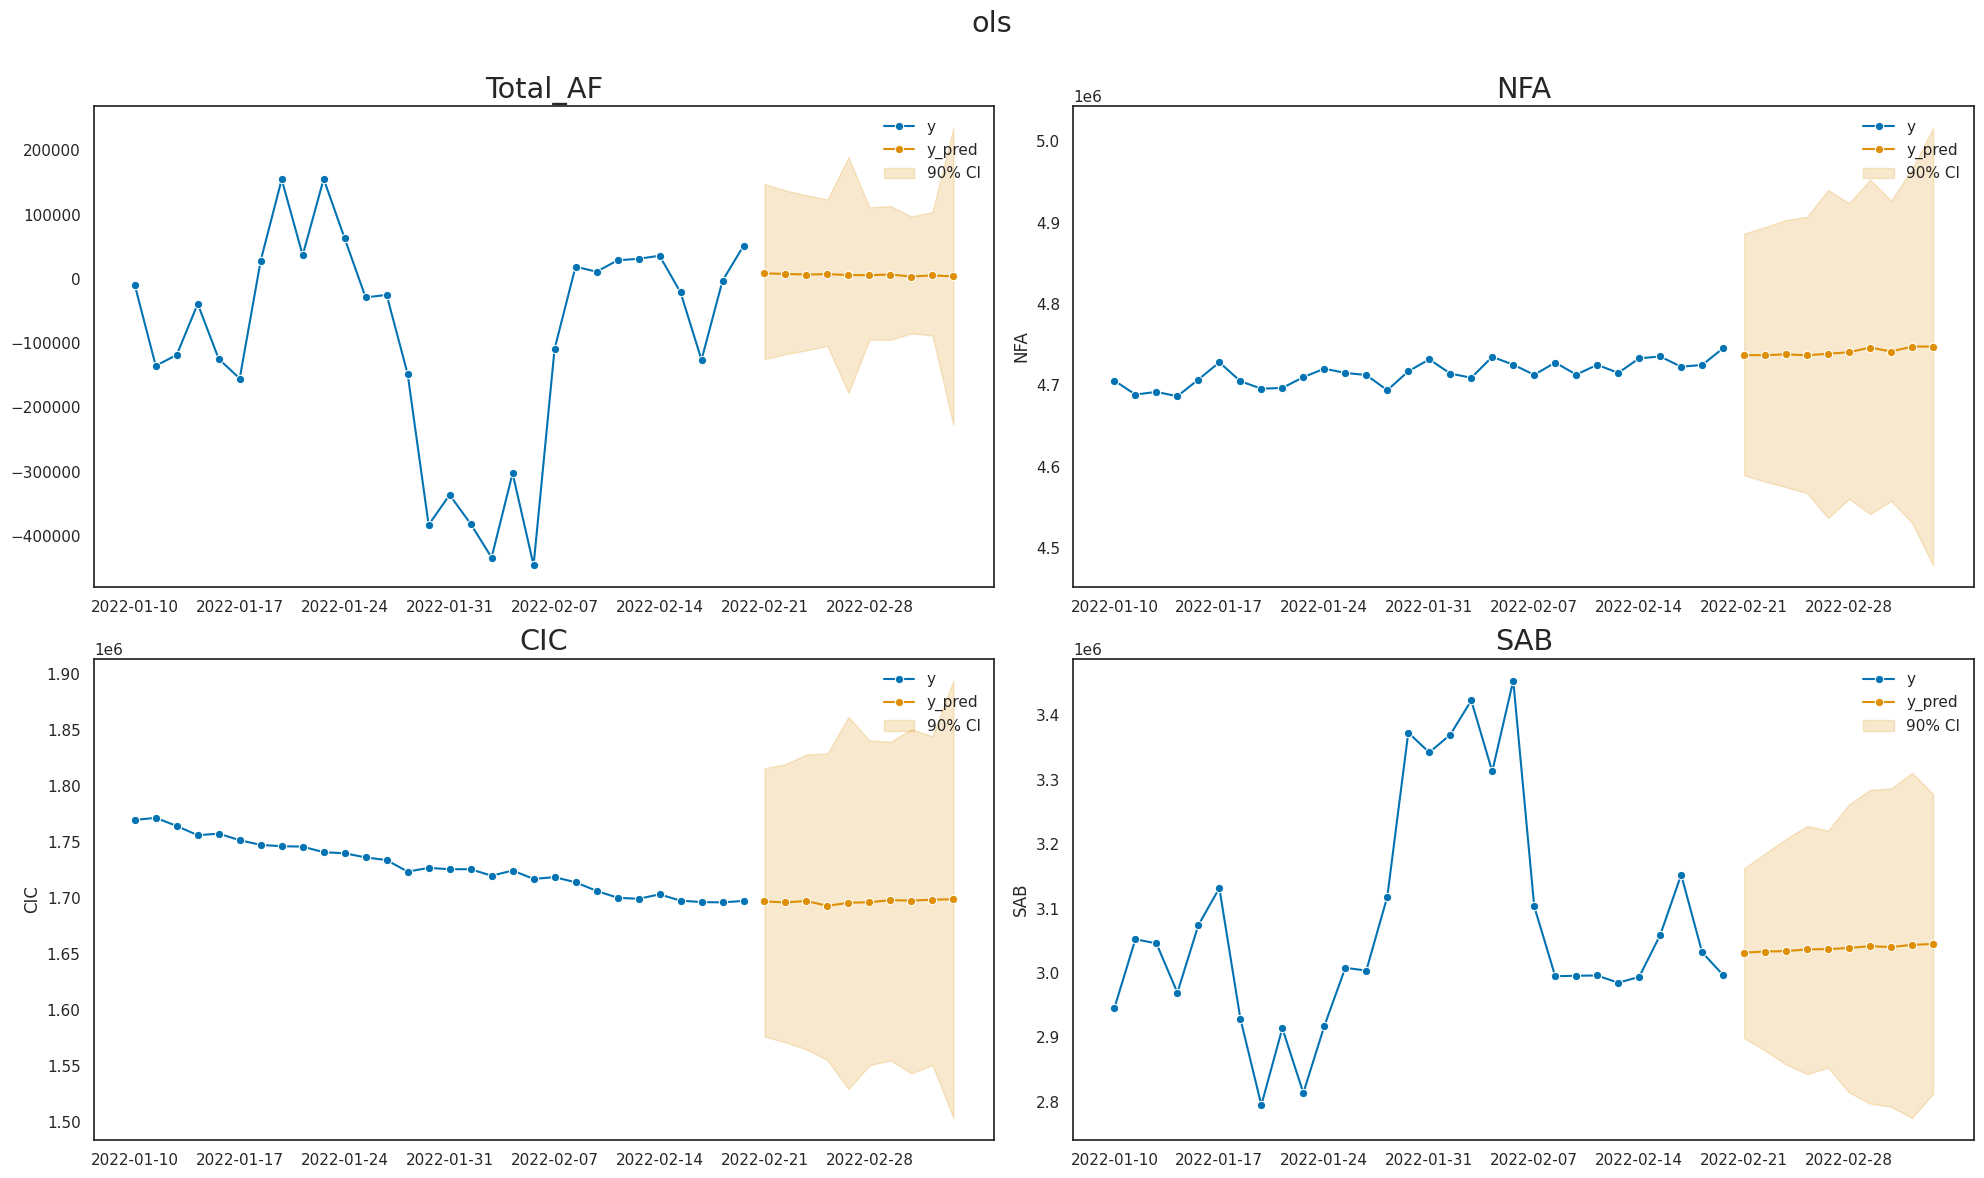

wls reconciliation method requires the forecasters prediction errors variance-covariance matrix ...


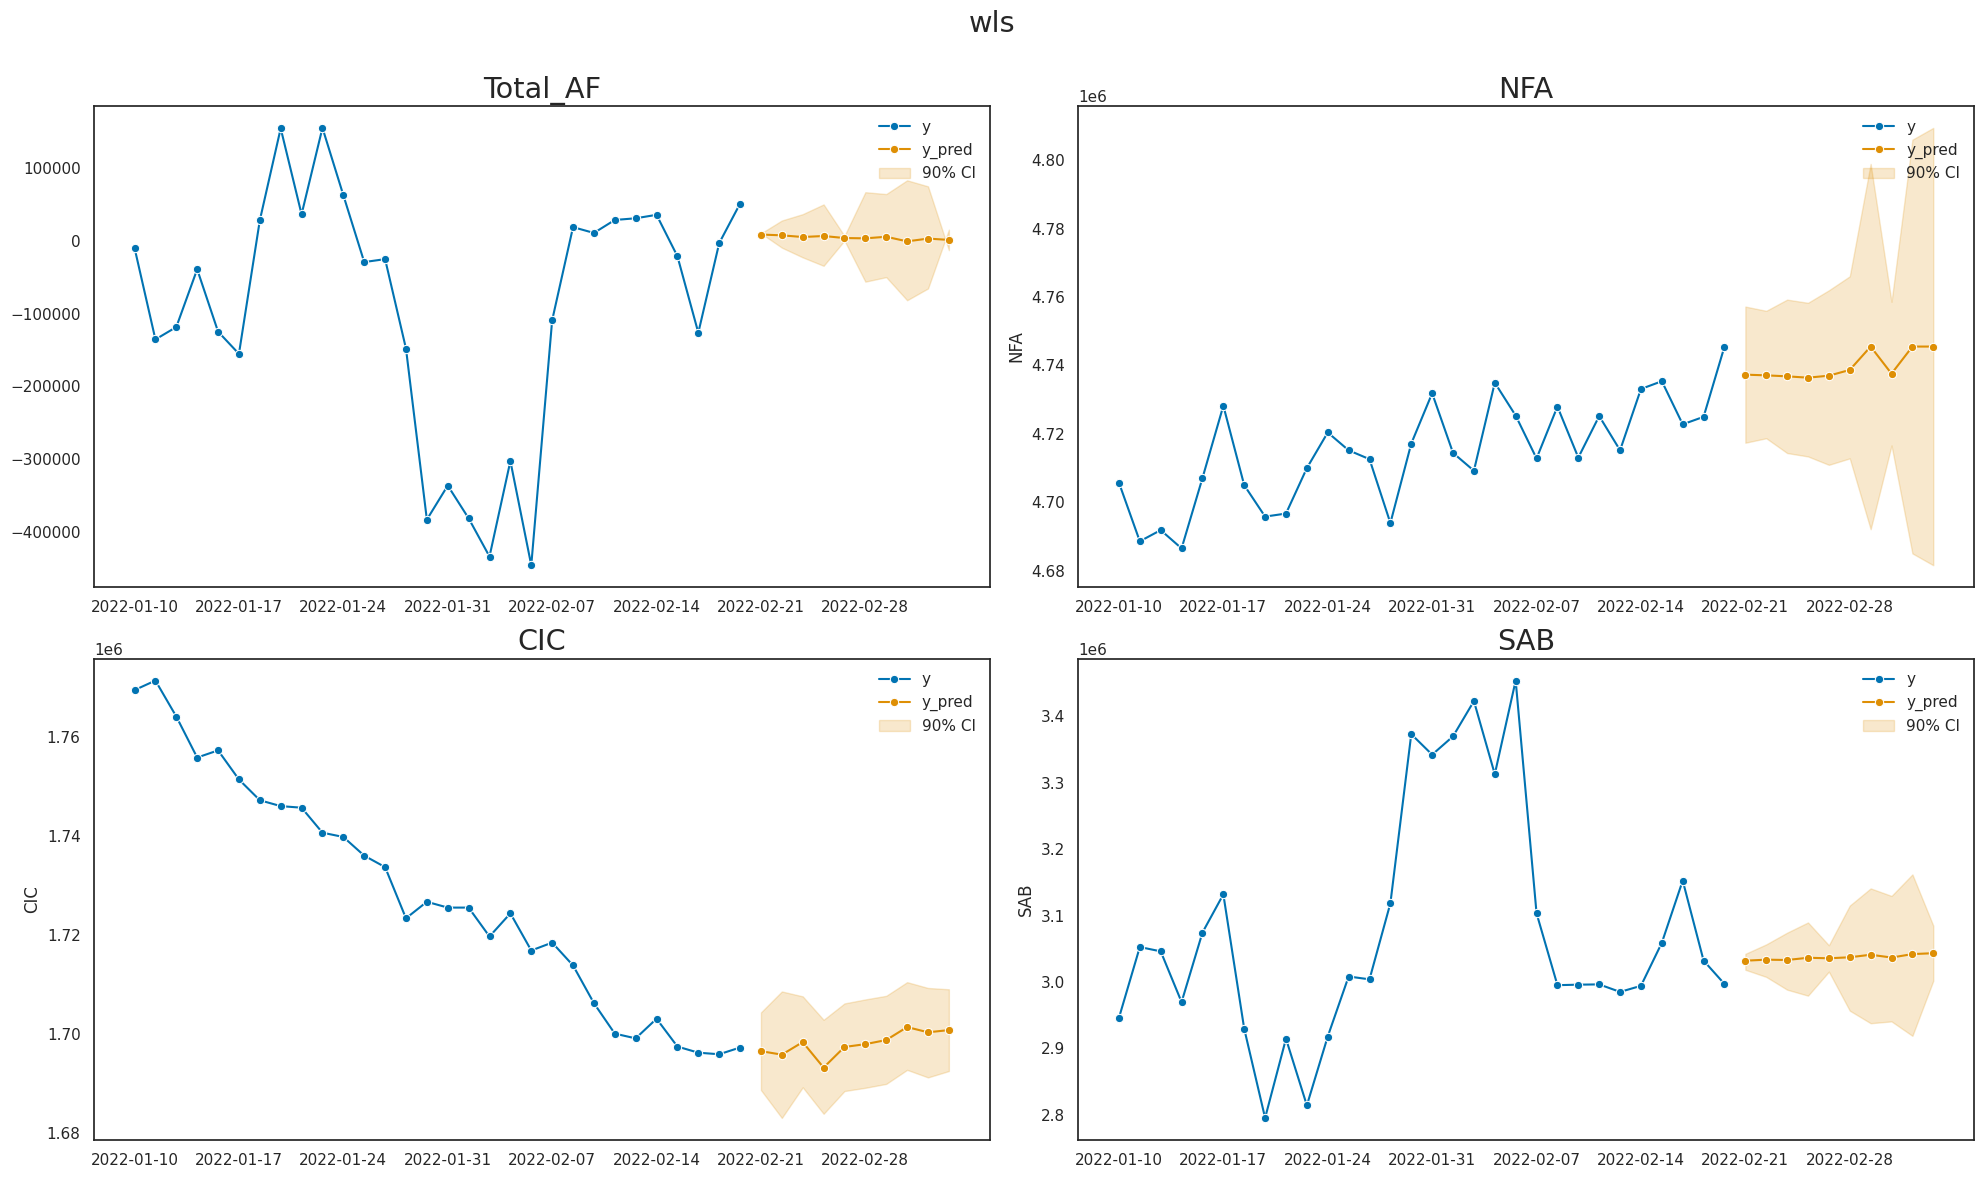

mint reconciliation method requires the forecasters prediction errors variance-covariance matrix ...


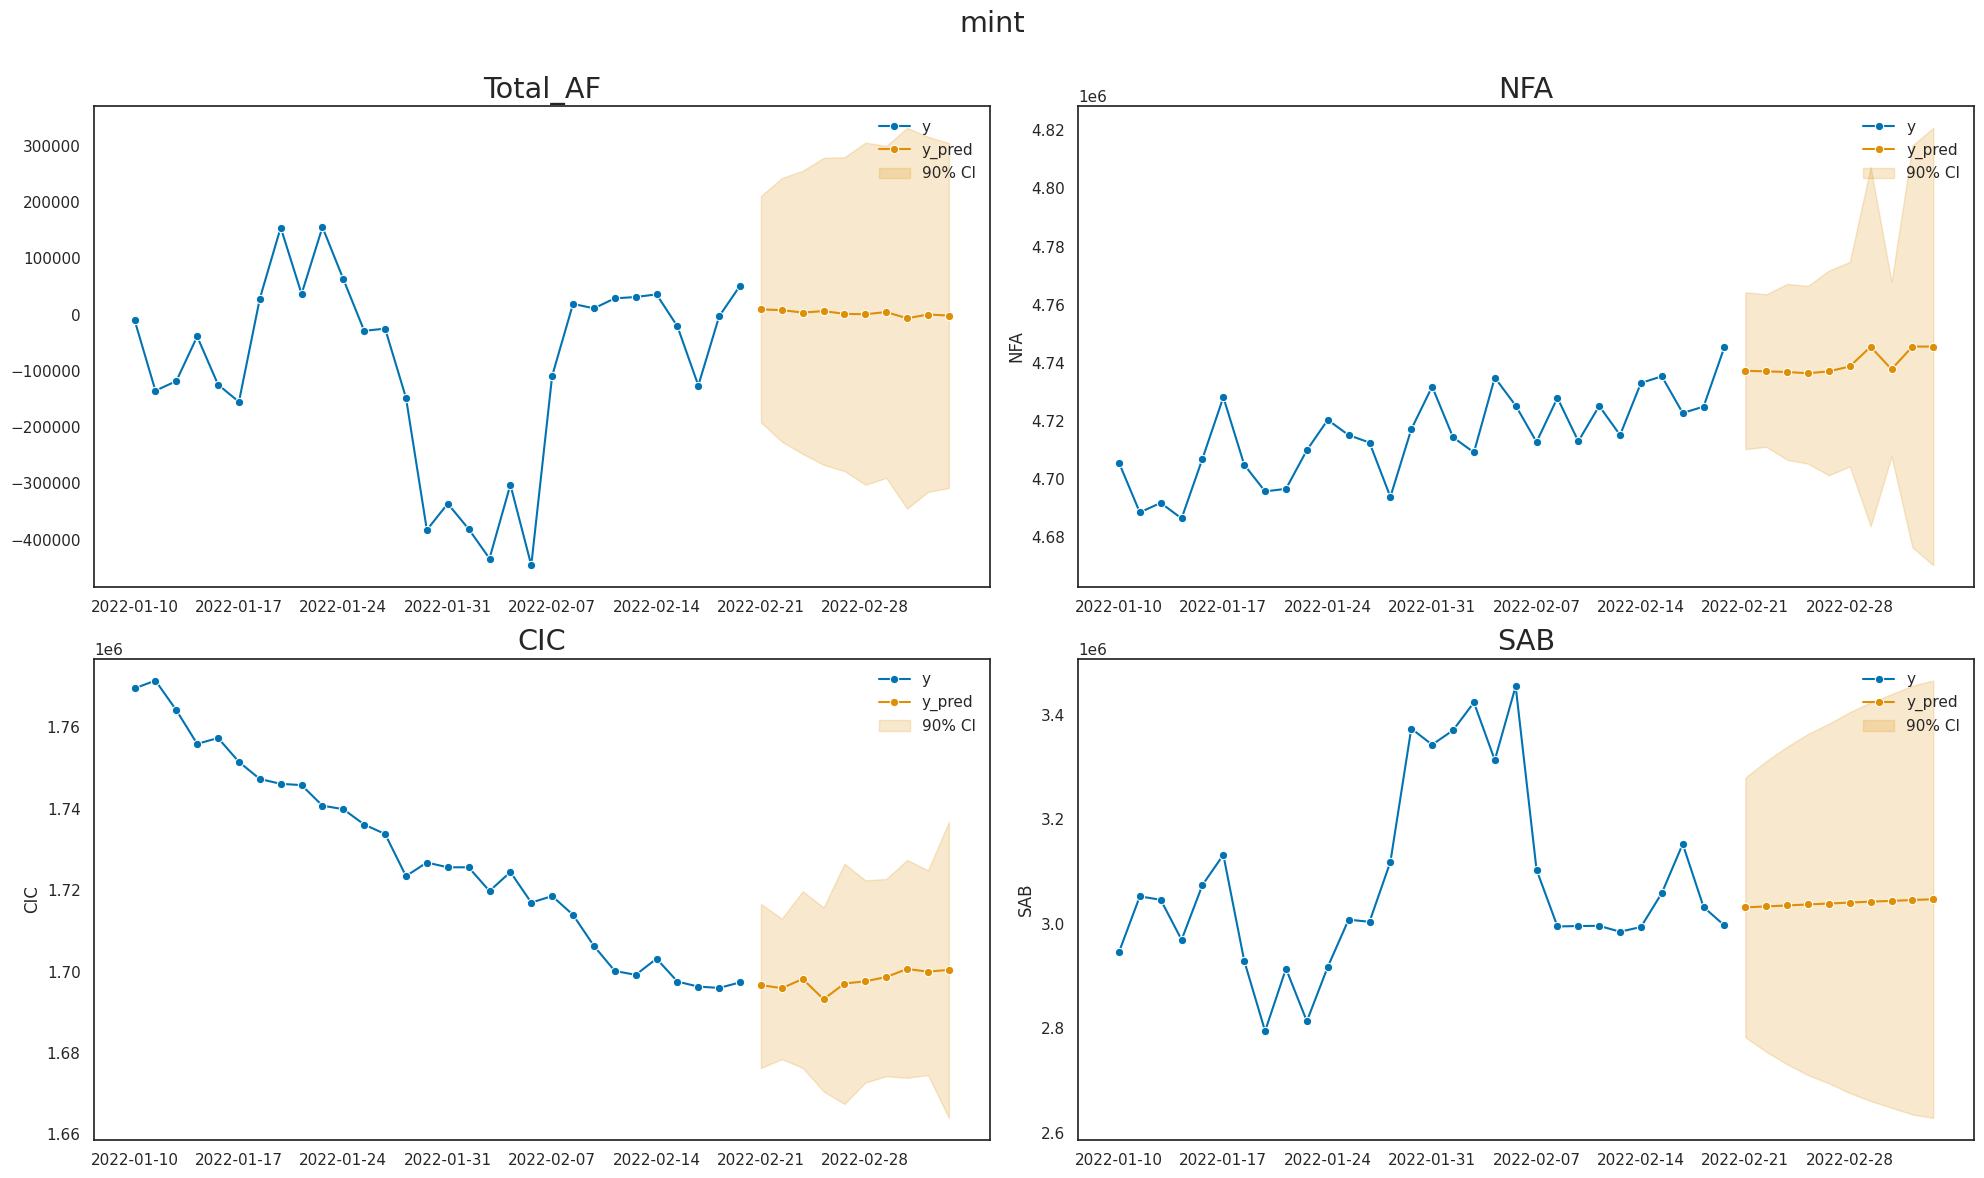

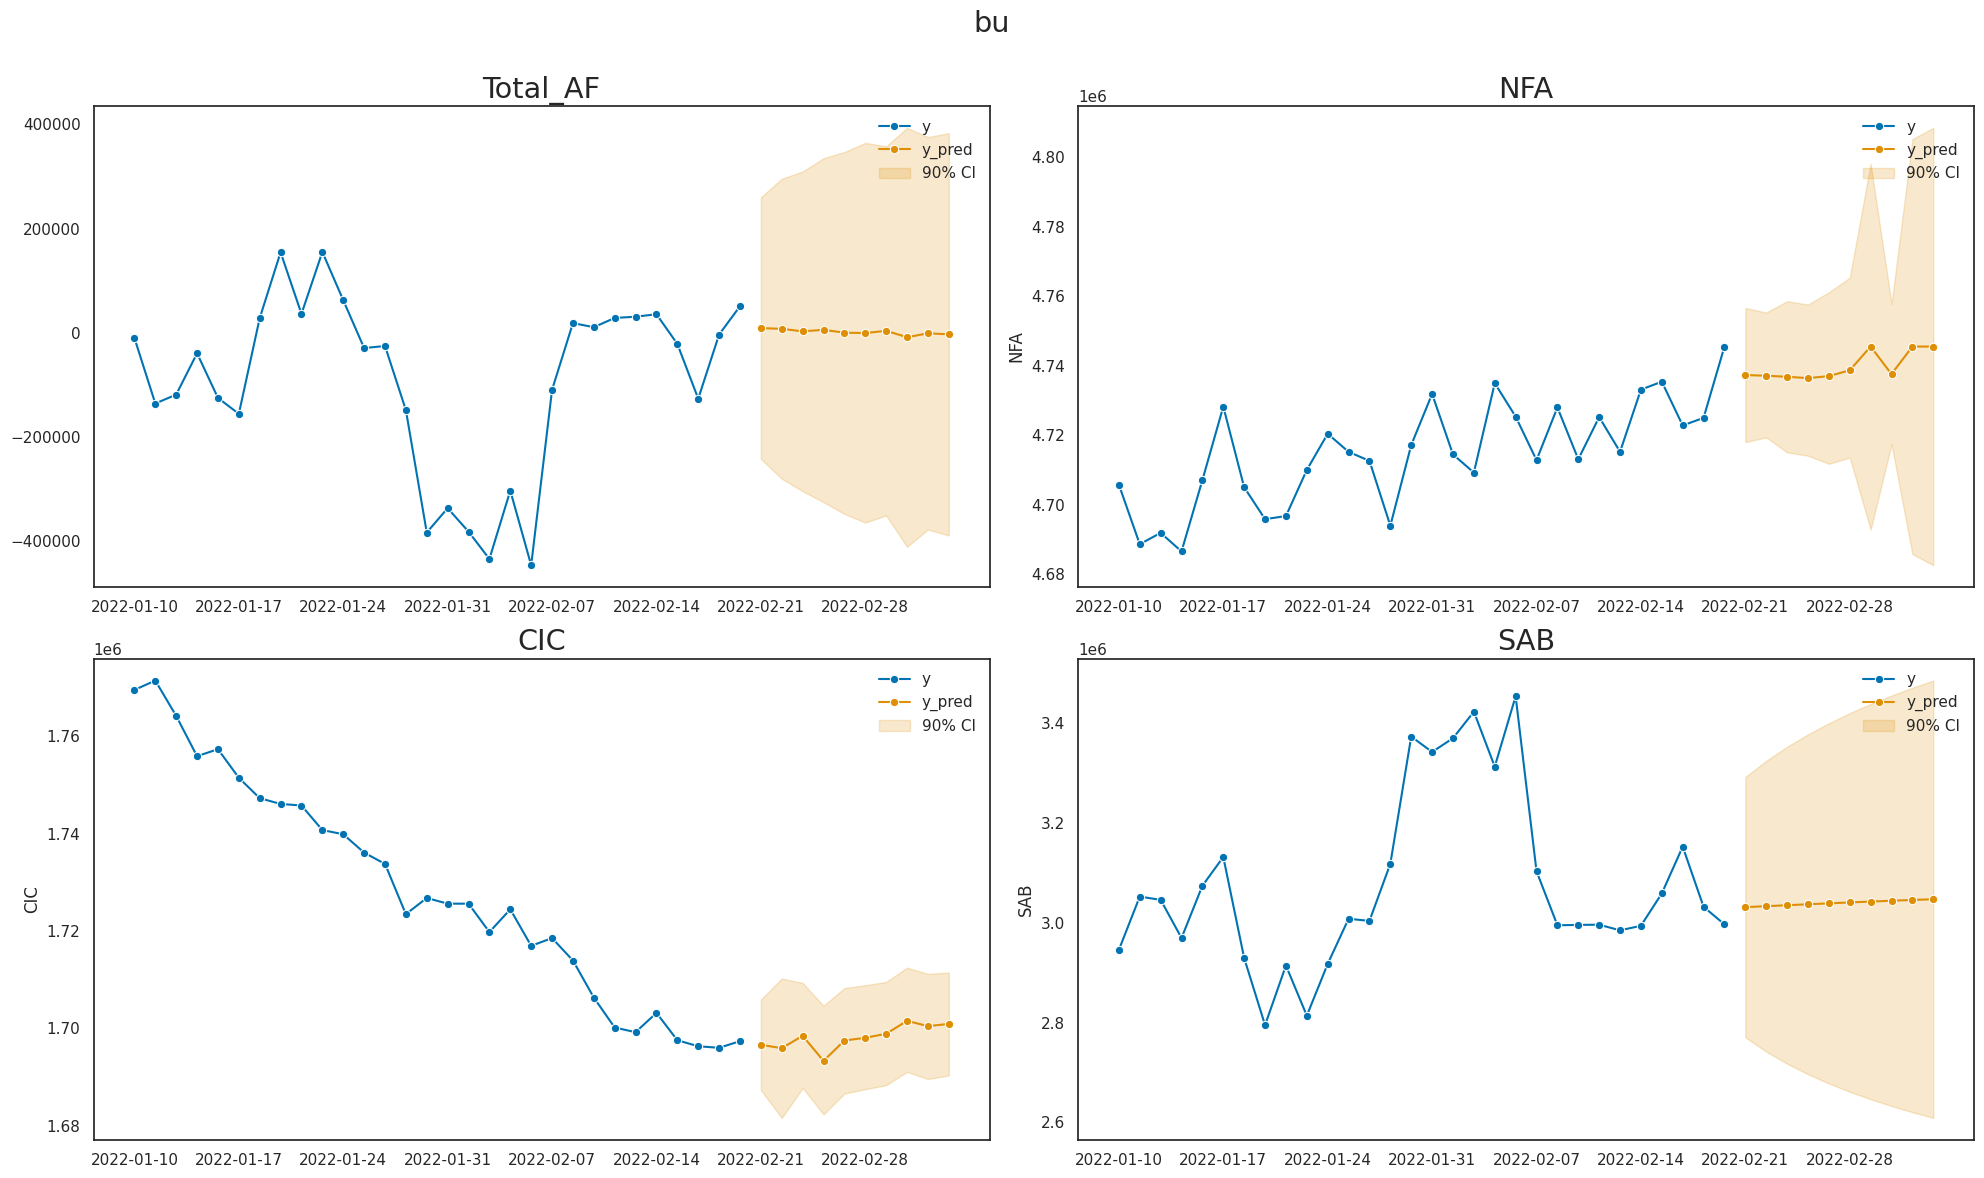

In [16]:
for m in ['mint', 'wls', 'ols', 'bu']:
    reconciled_preds, reconciled_intervals = reconciler.update(
        new_y={'Total_AF': Total_AF, 'NFA': NFA, 'CIC': CIC, 'SAB': SAB},
        new_X= {'NFA': NFA_X, 'CIC': CIC_X},
        reconciliation_method = m)
    reconciler.plot_predict(reconciled_preds, reconciled_intervals, title = m)
    plt.show()

In [26]:
with pd.ExcelWriter(f'forecast_output/Total_AF_prediction_after_reconciliation_{today}.xlsx') as writer:
    pd.DataFrame(reconciled_preds).to_excel(writer, sheet_name='mean_forecast', index=True)
    pd.concat(reconciled_intervals, axis=1).to_excel(writer, sheet_name='confidence_interval', index=True)